In [54]:
import os
import sys
import json
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BASE_DIR = '../mnt/inputs/origin'
TRN_BASE_DIR = '../mnt/inputs/features/train'
TST_BASE_DIR = '../mnt/inputs/features/test'
# BASE_DIR = '../mnt/inputs/features/test'

In [3]:
trn_df = pd.read_pickle(f'{BASE_DIR}/train.pkl.gz')
trn_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
tst_df = pd.read_csv(f'{BASE_DIR}/test.csv')
tst_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [5]:
label_df = pd.read_csv('../mnt/inputs/origin/train_labels.csv')
label_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [6]:
specs_df = pd.read_csv('../mnt/inputs/origin/specs.csv')
specs_df.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [7]:
sub_df = pd.read_csv('../mnt/inputs/origin/sample_submission.csv')
sub_df.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


## debug eda

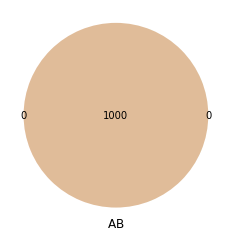

In [8]:
venn2([set(sub_df.installation_id), set(tst_df.installation_id)])

## ass_cum_acc debug

In [10]:
def assess_history(gr_df):
    gr_df = gr_df.sort_values("gs_max_time", ascending=True)

    gr_df["as_acc_c_num"] = gr_df["num_correct"].cumsum()
    gr_df["as_acc_inc_num"] = gr_df["num_incorrect"].cumsum()
    gr_df["as_prev_acc"] = gr_df["num_correct"] / \
        (gr_df["num_correct"] + gr_df["num_incorrect"])
    gr_df["as_cum_acc"] = gr_df["as_acc_c_num"] / \
        (gr_df["as_acc_c_num"] + gr_df["as_acc_inc_num"])

    shift_col = [
        "num_correct",
        "num_incorrect",
        "as_acc_c_num",
        "as_acc_inc_num",
        "as_prev_acc",
        "as_cum_acc"]
    gr_df[shift_col] = gr_df[shift_col].shift(1).fillna(-99)

    return gr_df

def ins_id_sessions(df):
    """session当該session直前までのactivityを示す
    Args:
        df: df grouped by installation_id
    """
    # 単純なactivity count
    df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform(
        "max")  # gs_max_timeでsortする必要がある

    c_ass_idx = ((df.event_code == 4100)
                 & (df.title != "Bird Measurer (Assessment)")
                 & (df["event_data"].str.contains("true"))) | \
        ((df.event_code == 4110)
         & (df.title == "Bird Measurer (Assessment)")
         & (df["event_data"].str.contains("true")))

    inc_ass_idx = ((df.event_code == 4100)
                   & (df.title != "Bird Measurer (Assessment)")
                   & (df["event_data"].str.contains("false"))) | \
        ((df.event_code == 4110)
         & (df.title == "Bird Measurer (Assessment)")
         & (df["event_data"].str.contains("false")))

    df.loc[c_ass_idx, 'num_correct'] = 1
    df.loc[inc_ass_idx, 'num_incorrect'] = 1

    df["num_correct"].fillna(0, inplace=True)
    df["num_incorrect"].fillna(0, inplace=True)

    df = df.loc[(df.type == "Assessment")]

    df = df.groupby(["installation_id", "game_session", "gs_max_time", "title"])[
        ["num_correct", "num_incorrect"]].sum().reset_index()

    df = df.groupby("title").apply(assess_history)
    df = df.sort_values("gs_max_time", ascending=True)

    del df["title"], df["gs_max_time"]

#    if self.datatype == "test":
#        df = pd.DataFrame([df.iloc[-1, :]])

    return df

In [11]:
trn_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [12]:
label_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [13]:
ins_id_sessions(trn_df.query('installation_id == "0006a69f"'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

installation_id      game_session  num_correct  \
title                                                                           
Mushroom Sorter (Assessment) 2        0006a69f  901acc108f55a5a1        -99.0   
Bird Measurer (Assessment)   1        0006a69f  77b8ee947eb84b4e        -99.0   
Mushroom Sorter (Assessment) 0        0006a69f  6bdf9623adc94d89          1.0   
                             5        0006a69f  e7e7db2a241eadcc          1.0   
                             3        0006a69f  9501794defd84e4d          0.0   
Bird Measurer (Assessment)   4        0006a69f  a9ef3ecb3d1acc6a          0.0   

                                num_incorrect  as_acc_c_num  as_acc_inc_num  \
title                                                                         
Mushroom Sorter (Assessment) 2          -99.0         -99.0           -99.0   
Bird Measurer (Assessment)   1          -99.0         -99.0           -99.0   
Mushroom Sorter (Assessment) 0            0.0           1.0             0.0   
                             5            0.0           2.0             0.0   
                             3            0.0           2.0             0.0   
Bird Measurer (Assessment)   4           11.0           0.0            11.0   

                                as_prev_acc  as_cum_acc  
title                                                    
Mushroom Sorter (Assessment) 2        -99.0       -99.0  
Bird Measurer (Assessment)   1        -99.0       -99.0  
Mushroom Sorter (Assessment) 0          1.0         1.0  
                             5          1.0         1.0  
                             3        -99.0         1.0  
Bird Measurer (Assessment)   4          0.0         0.0

In [15]:
trn_df.query('game_session == "901acc108f55a5a1"').sort_values('timestamp').drop_duplicates('game_session')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2185,3bfd1a65,901acc108f55a5a1,2019-08-06T05:22:01.344Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [16]:
trn_df.query('game_session == "6bdf9623adc94d89"').sort_values('timestamp').drop_duplicates('game_session')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2768,3bfd1a65,6bdf9623adc94d89,2019-08-06T05:37:50.020Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [17]:
trn_df.query('game_session == "e7e7db2a241eadcc"').sort_values('timestamp').drop_duplicates('game_session')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
3680,3bfd1a65,e7e7db2a241eadcc,2019-08-06T20:34:35.357Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [18]:
trn_df.query('game_session == "9501794defd84e4d"').sort_values('timestamp').drop_duplicates('game_session')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
3697,3bfd1a65,9501794defd84e4d,2019-08-06T20:34:53.812Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [41]:
df1 = pd.read_pickle('../mnt/inputs/features/train/PrevAssessAcc.pkl')
df2 = pd.read_pickle('../mnt/inputs/features/test/PrevAssessAcc.pkl')

In [31]:
df1_sesslen = pd.read_pickle('../mnt/inputs/features/train/befTargetCntFeatures.pkl')

In [62]:
last_sess = df1_sesslen.sort_values(['installation_id', 'game_session', 'f019_bef_target_cnt']).drop_duplicates('installation_id', keep='last').game_session

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


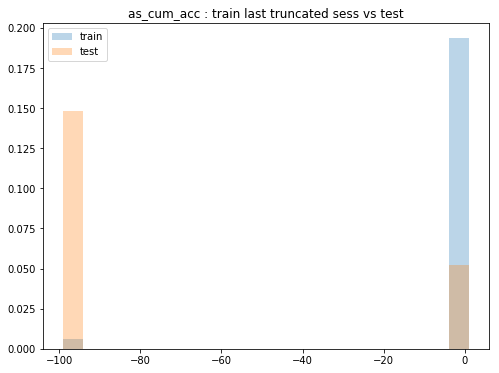

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# bins = np.linspace()
ax.hist(df1.query(f'game_session in {tuple(last_sess)}').as_cum_acc, label='train', bins=20, alpha=0.3, normed=True)
ax.hist(df2.as_cum_acc, label='test', bins=20, alpha=0.3, normed=True)

ax.set_title('as_cum_acc : train last truncated sess vs test')
ax.legend()

plt.show()

In [51]:
kb_trn_df = pd.read_pickle('../mnt/inputs/features/train/KernelBasics3.pkl')

In [52]:
kb_trn_df.shape

(17690, 65)

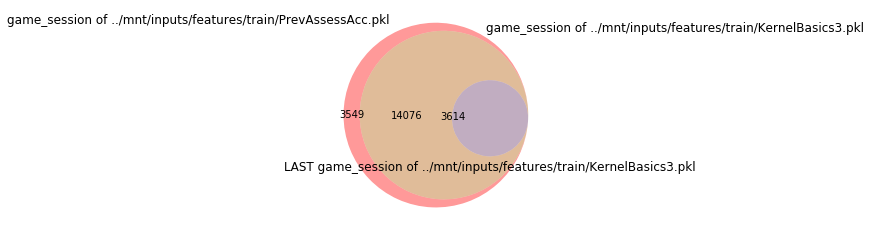

In [63]:
venn3(
    [set(df1.game_session), set(kb_trn_df.game_session), set(last_sess)],
    set_labels=[
        'game_session of ../mnt/inputs/features/train/PrevAssessAcc.pkl',
        'game_session of ../mnt/inputs/features/train/KernelBasics3.pkl',
        'LAST game_session of ../mnt/inputs/features/train/KernelBasics3.pkl',
    ]
)

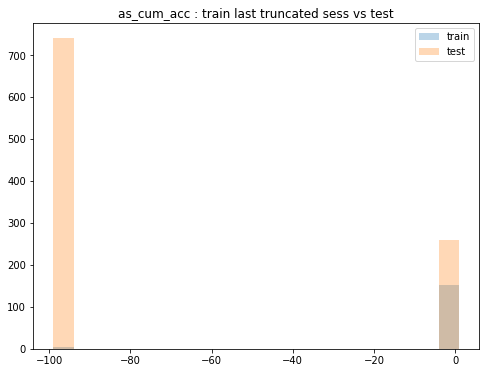

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# bins = np.linspace()
ax.hist(df1.query(f'game_session in {tuple(last_sess)}').as_cum_acc, label='train', bins=20, alpha=0.3)
ax.hist(df2.as_cum_acc, label='test', bins=20, alpha=0.3)

ax.set_title('as_cum_acc : train last truncated sess vs test')
ax.legend()

plt.show()

In [ ]:
df1.

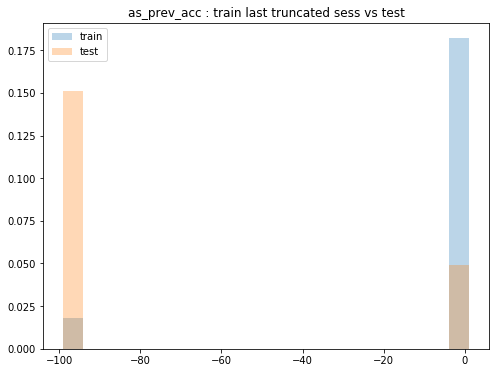

In [36]:
FEATURE = 'as_prev_acc'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# bins = np.linspace()
ax.hist(df1.query(f'game_session in {tuple(last_sess)}')[FEATURE], label='train', bins=20, alpha=0.3, normed=True)
ax.hist(df2[FEATURE], label='test', bins=20, alpha=0.3, normed=True)

ax.set_title(f'{FEATURE} : train last truncated sess vs test')
ax.legend()

plt.show()

In [38]:
df1 = pd.read_pickle('../mnt/inputs/features/train/KernelBasics3.pkl')
df2 = pd.read_pickle('../mnt/inputs/features/test/KernelBasics3.pkl')

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


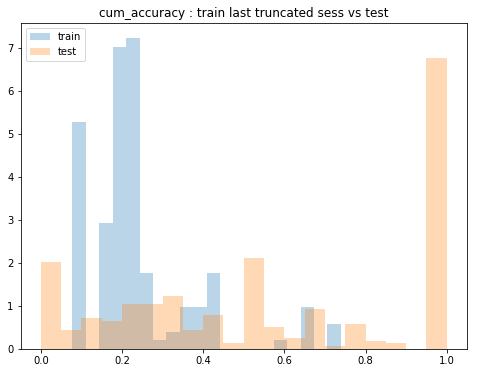

In [39]:
FEATURE = 'cum_accuracy'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# bins = np.linspace()
ax.hist(df1.query(f'game_session in {tuple(last_sess)}')[FEATURE], label='train', bins=20, alpha=0.3, normed=True)
ax.hist(df2[FEATURE], label='test', bins=20, alpha=0.3, normed=True)

ax.set_title(f'{FEATURE} : train last truncated sess vs test')
ax.legend()

plt.show()